# Stroke Prediction 

**Introduction**

This project is centered on around developing machine learning models to predict the likelihood of stroke in patients. By analyzing our patient  data, we aim to identify key risk factors associated with strokes. We will be designing a model that will work as an asset for our health care professionals, enabling them to screen and identify individuals at higher risk efficiently.

**Imports**

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from joblib import dump
from scipy.stats import expon, randint as sp_randint, reciprocal, uniform
from scipy.stats import pointbiserialr
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (average_precision_score, auc,
                             classification_report, confusion_matrix,
                             precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.model_selection import (RandomizedSearchCV, StratifiedKFold,
                                     cross_val_predict, train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import (MinMaxScaler, OneHotEncoder, RobustScaler,
                                   StandardScaler)
from sklearn.svm import SVC
from xgboost import XGBClassifier

import shap
from category_encoders import TargetEncoder

from functions import (build_pipeline, confusion_matrix_df,
                       create_preprocessor, custom_cross_validation,
                       extract_feature_importances, make_common_preprocessing,
                       multiple_test_chi2, mutiple_test_mann_whitney,
                       random_search_cv)
from plot_utils import annotate_bars, hide_spines, plot_model_evaluation

In [61]:
plt.style.use('deeplearning.mplstyle')
%config InlineBackend.figure_format = 'svg'
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_blue = default_colors[0]
%load_ext autoreload
%autoreload 2

**Data Overview & Cleaning**

In [3]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.shape

(5110, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
df.isnull().sum() / df.shape[0] * 100

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [8]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [9]:
df.loc[df['gender'] == 'Other', 'gender'] = 'Female'

In [10]:
df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [11]:
unknown_smokers = df[df['smoking_status'] == 'Unknown']
unknown_smokers[unknown_smokers['age'] <= 10].shape

(497, 12)

In [12]:
df.loc[(df['smoking_status'] == 'Unknown') & (df['age'] < 10),
       'smoking_status'] = 'never smoked'

In [13]:
df[df['work_type'] == 'children'].head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,never smoked,1
245,49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1
249,30669,Male,3.00,0,0,No,children,Rural,95.12,18.0,never smoked,0
282,33759,Female,3.00,0,0,No,children,Urban,73.74,16.0,never smoked,0
290,55680,Male,13.00,0,0,No,children,Urban,114.84,18.3,Unknown,0


In [14]:
df.duplicated().sum()

0

- After reviewing our data, we noticed some missing values in the BMI feature. For the EDA phase, I chose to leave these missing values untouched. This approach, considering the missing data is only 3.8% of the BMI column, ensures our analysis stays true to the original dataset without the risk of bias from early imputation. When we arrive at the modeling stage, we will try different imputation techniques in order to fill those missing values.

- Another observation was that we have a category "Unknown" for  smoking status. Referring back to the source of the dataset it states "Unknown means that the information is unavailable for this patient". After checking the age of the patients in this Unknown category, we found approximately 500 patients who were less then our equal to 10 years old. I have decided to move them into the never smoked category, as its very uncommon that people the age of 10 and below are smoking. As for work type we also observed there is a children category, which signifies children, not people who work with children.

**What are some of the attributes of our patients and how are they related to having a stroke?**

In [15]:
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
cat_cols = df[[col for col in df.columns
               if col not in numerical_cols]].columns[1:]

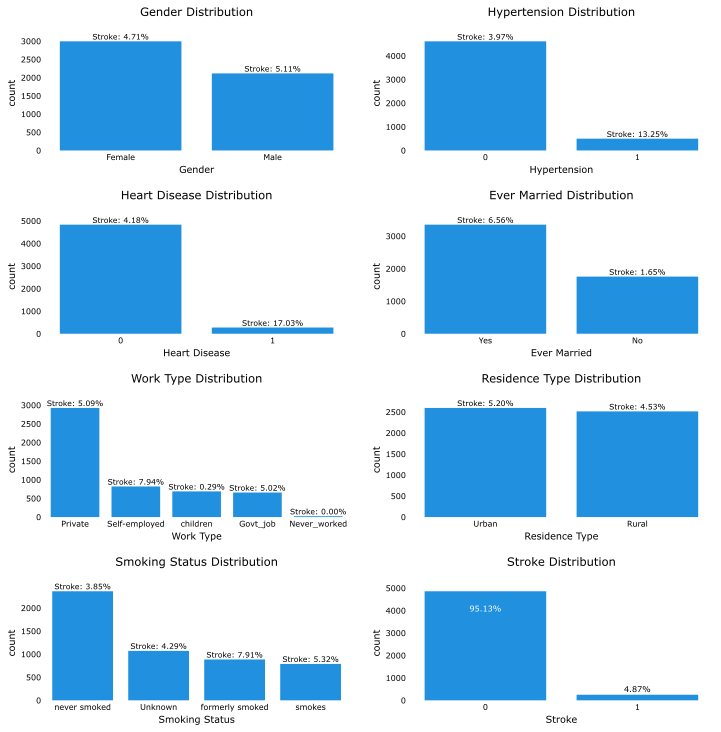

In [16]:
plt.figure(figsize=(12, 12))
for i, col in enumerate(cat_cols, start=1):
    plt.subplot(4, 2, i)
    order = df[col].value_counts().index
    fig = sns.countplot(x=col, data=df, color=default_blue, order=order)
    hide_spines(fig)
    if col != 'stroke':
        stroke_proportion = (df.groupby(col)['stroke'].mean()[order]) * 100
        for index, value in enumerate(order):
            height = fig.patches[index].get_height()
            plt.text(index,
                     height + 10,
                     f'Stroke: {stroke_proportion[value]:.2f}%',
                     color='black',
                     ha="center",
                     va="bottom",
                     fontsize=7.6)
    else:
        annotate_bars(fig, percentage=True, offset_ratio=0.2)

    plt.title(f"{col.title().replace('_', ' ')} Distribution", pad=20)
    plt.xlabel(f"{col.title().replace('_', ' ').title()}")
plt.subplots_adjust(hspace=0.6, wspace=0.2)
plt.show()

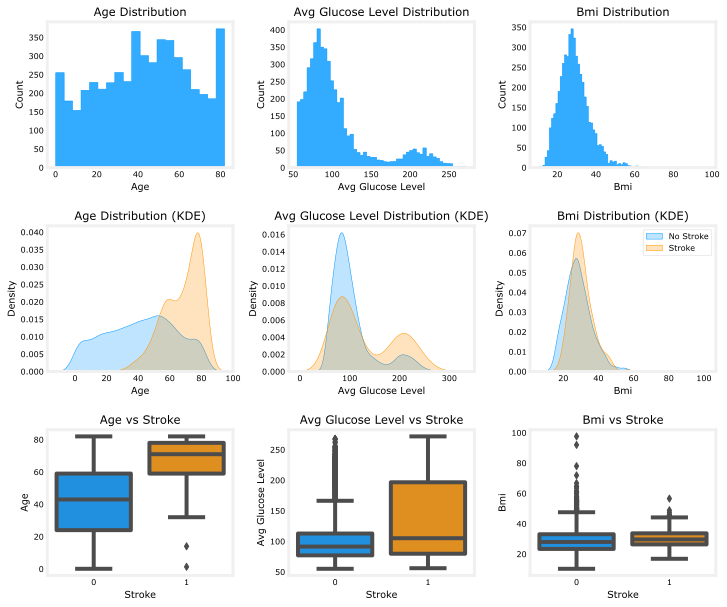

In [17]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(numerical_cols, start=1):
    formatted_col = col.title().replace('_', ' ')

    plt.subplot(3, 3, i)
    plt.title(f"{formatted_col} Distribution")
    plt.xlabel(formatted_col)
    sns.histplot(x=df[col], element="step", common_norm=False, alpha=0.8)

    plt.subplot(3, 3, i + 3)
    plt.title(f"{formatted_col} Distribution (KDE)")
    plt.xlabel(formatted_col)
    sns.kdeplot(df[df['stroke'] == 0][col], fill=True, label='No Stroke')
    sns.kdeplot(df[df['stroke'] == 1][col], fill=True, label='Stroke')
    if i == 3:
        plt.legend()

    plt.subplot(3, 3, i + 6)
    plt.title(f"{formatted_col} vs Stroke")
    sns.boxplot(x="stroke", y=col, data=df)
    plt.xlabel("Stroke")
    plt.ylabel(formatted_col)

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

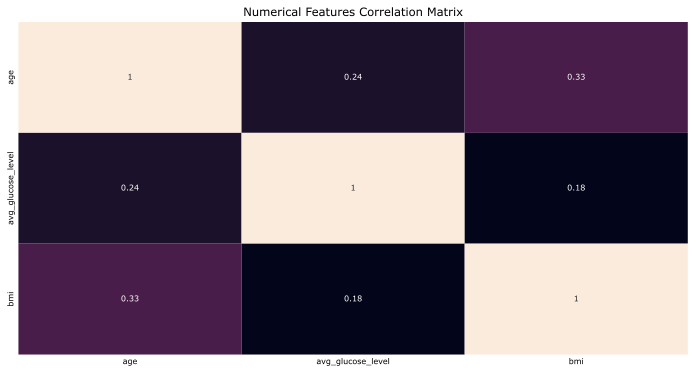

In [18]:
df_corr = df[['age', 'avg_glucose_level', 'bmi', 'stroke']].dropna()
plt.figure(figsize=(12, 6))
plt.title('Numerical Features Correlation Matrix')
sns.heatmap(df_corr[['age', 'avg_glucose_level', 'bmi']].corr(),
            annot=True,
            cbar=False)
plt.show()

In [19]:
for col in numerical_cols:
    correlation, p_value = pointbiserialr(df_corr[col], df_corr['stroke'])
    print(
        f"Correlation between {col} and stroke: {correlation}, P-value: {p_value}"
    )

Correlation between age and stroke: 0.2323308555348496, P-value: 3.6556933219810176e-61
Correlation between avg_glucose_level and stroke: 0.13893586200507024, P-value: 1.3799691107259855e-22
Correlation between bmi and stroke: 0.042373661149233556, P-value: 0.002983269099742051


**Summary of Patient Attributes and Their Relations to Stroke**:  
- **Gender**: The dataset comprises 58% females and 42% males. The stroke incidence is 4.7% for females and 5.1% for males, showing no clear gender trends in stroke occurrence.
- **Hyper Tension**: About 90% of patients do not have hypertension, while 10% do. Stroke rates are 13% in hypertensive patients and 4% in non-hypertensive patients.
- **Heart Disease**: 95% of patients have no heart disease, 5% do. Patients with heart disease show a 17% stroke incidence, compared to 4% in those without.
- **Ever Married**: 65% of patients have been married. Stroke incidence is 6.5% in married individuals and 1.6% in unmarried ones.
- **Work Type**: Most patients are privately employed (57%). Stroke rates are about 5% in both private and government jobs, 8% in self-employed individuals, and 0-0.3% in children or those never worked.
- **Residence**: 51% of patients reside in urban areas, 49% in rural. Urban areas have a 5.2% stroke rate, rural areas 4.53%.
- **Smoking Status**: 46% never smoked, 21% unknown status, 17% former smokers, 15% current smokers. Former smokers have the highest stroke rate at 7.91%, followed by current smokers at 5%.
- **Stroke**: This target variable shows a class imbalance with 95% of patients never having a stroke and 5% having one.
- **Age**: Age range is from babies to 82 years. The average age for stroke patients is 68 years, compared to 41 years for non-stroke patients. The median age is 71 years for stroke patients and 43 years for non-stroke patients, indicating a higher stroke frequency in the 60-80 age group. A few stroke cases exist under 20 years.
- **Average Glucose Level**: Median average glucose is 91 for non-stroke patients and 105 for stroke patients, with more variability and outliers in stroke patients' glucose levels.
- **BMI**: The median BMI is 28 for non-stroke patients and 30 for stroke patients, with outliers in both groups.

- **Correlation** : We conducted a Pearson correlation analysis and found mild positive correlations among our numerical features: age and BMI (0.33), age and average glucose level (0.24), and a slighter correlation between average glucose level and BMI (0.18). To explore the relationship between our binary outcome (stroke occurrence) and numerical features, we applied the point-biserial correlation method. The results indicated a moderate positive correlation between age and stroke incidence (corr = 0.232, p < 0.0001), a weaker but significant correlation with average glucose levels (r = 0.139, p < 0.0001), and a small correlation with BMI (r = 0.042, p = 0.0029).

- **Medical Perspective** - From a medical perspective, some of the key factors that we observed that impacts stroke risk are age where the middle 50% of the patients who suffered from a stroke tended to be between 60-80 years old with a few exceptions, hyper tension where we observed that the proportion of people who had a stroke with hyper tension (13%) is much larger then those who do not (4%). Heart disease also displayed that out of the people who have heart disease 17% suffered from a stroke while only 4% of those who did not. Smoking status and work type also displayed small trends where people who smoke or smoked and people are self employed had slightly higher stroke rates.

**Is there a significant association between our categorical features and the occurrence of a stroke?**

**Null Hypothesis** : There is no association between a specific categorical feature (e.g., smoking status) and the occurrence of a stroke.  
**Alternative Hypothesis**: There is an association between a specific categorical feature and the occurrence of a stroke.

In [20]:
categorical_cols = list(cat_cols[:-1])

In [21]:
alpha = 0.05 / len(categorical_cols)
alpha

0.0071428571428571435

In [22]:
chi2_dict = multiple_test_chi2(df, categorical_cols, 'stroke')
chi2_dict

{'gender': [0.5580285118426893, 0.34312923759376157],
 'hypertension': [1.661621901511823e-19, 81.6053682482931],
 'heart_disease': [2.0887845685229236e-21, 90.25956125843324],
 'ever_married': [1.6389021142314745e-14, 58.923890259034195],
 'work_type': [5.397707801896119e-10, 49.163511976675295],
 'Residence_type': [0.29833169286876987, 1.0816367471627524],
 'smoking_status': [2.4076350124028434e-05, 24.076640434966958]}

In [23]:
[(f, v[0]) for f, v in chi2_dict.items() if v[0] < alpha]

[('hypertension', 1.661621901511823e-19),
 ('heart_disease', 2.0887845685229236e-21),
 ('ever_married', 1.6389021142314745e-14),
 ('work_type', 5.397707801896119e-10),
 ('smoking_status', 2.4076350124028434e-05)]

- We performed multiple Chi-Square tests to see if there is an association between our categorical features and the occurrence of a stroke. We utilized bonferroni correction to create our alpha (0.007), which takes into to account the multiple hypothesis test being performed. The resulting dictionary displays the corresponding p-values for each feature.

- We reject the null hypothesis for features hypertension, heart disease, ever married, work type and smoking status, thus concluding there is an association between these variables and the occurrence of a stroke. We fail to reject the null hypothesis for gender and residence type, concluding there is not a significant association between those variables and the occurrence of a stroke.

**Is there a significant difference in the distribution of our numerical features between individuals who have had a stroke and those who have not?**

**Null Hypothesis**:There is no difference in the distribution of a specific numerical feature (e.g., age) between individuals who have had a stroke and those who have not.  
**Alternative Hypothesis**: There is a difference in the distribution of a specific numerical feature (e.g., age) between individuals who have had a stroke and those who have not.

In [24]:
alpha = 0.05 / len(numerical_cols)
alpha

0.016666666666666666

In [25]:
mutiple_test_mann_whitney(df, numerical_cols, 'stroke')

{'age': 3.726634665900011e-71,
 'avg_glucose_level': 3.6403672710893236e-09,
 'bmi': 0.00010264290844688746}

- We performed a Mann–Whitney U test for our numerical features. We utilized a non parametric test due to the our data not following a normal distribution which is an assumption when using a test like a t-test. Same as for our testing about we used bonferroni correction to create our alpha (0.016).

- We reject the null hypothesis for age, average glucose level, and bmi, concluding that there is a significant difference between the distributions of people who have and have not suffered a stroke.

**Baseline Model**

In [26]:
X = df.drop(columns=['id', 'stroke'])
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [27]:
print('Training Class Distribution')
print(y_train.value_counts())
print('--------------------')
print('Testing Class Distribution')
print(y_test.value_counts())

Training Class Distribution
0    3889
1     199
Name: stroke, dtype: int64
--------------------
Testing Class Distribution
0    972
1     50
Name: stroke, dtype: int64


In [28]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train, y_train)
dummy_preds = dummy_clf.predict(X_test)
print(classification_report(y_test, dummy_preds))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       972
           1       0.05      0.04      0.04        50

    accuracy                           0.91      1022
   macro avg       0.50      0.50      0.50      1022
weighted avg       0.91      0.91      0.91      1022



- So before diving into more complex pipelines and models, we want to establish some sort of baseline that we can compare against. We can see the model performed very well for predicting not stroke but almost near 0 in all metrics when trying to predict the positive class. This is due to the big imbalance of the classes. There is a few techniques we will try in order to solve this issue later in the notebook.

- I would also like to address that our main metric of interest here will be recall. Why? Having a higher recall will reduce the amount of false negatives, from a medical perspective, false negatives for such serious medical conditions like a stroke are much more costly than false positives (precision). Obviously the idea is to have a good balance between the two (precision and recall), but the metric we will be trying to optimize for is recall.

**Mutual Information**

In [29]:
categorical_cols_not_encoded = [
    c for c in categorical_cols if c not in ['hypertension', 'heart_disease']
]
categorical_cols_encoded = ['hypertension', 'heart_disease']

In [30]:
mi_pipeline = create_preprocessor(numerical_cols, categorical_cols_not_encoded,
                                  categorical_cols_encoded,
                                  SimpleImputer(strategy='mean'),
                                  'passthrough', TargetEncoder())

total_mi_scores = np.zeros(len(numerical_cols + categorical_cols))
for _ in range(10):
    mi_pipeline.fit(X_train, y_train)
    X_train_transformed = mi_pipeline.transform(X_train)
    mi_scores = mutual_info_classif(X_train_transformed, y_train)
    total_mi_scores += mi_scores
average_mi_scores = total_mi_scores / 10
mi_scores_series = pd.Series(
    average_mi_scores,
    index=mi_pipeline.get_feature_names_out()).sort_values(ascending=False)

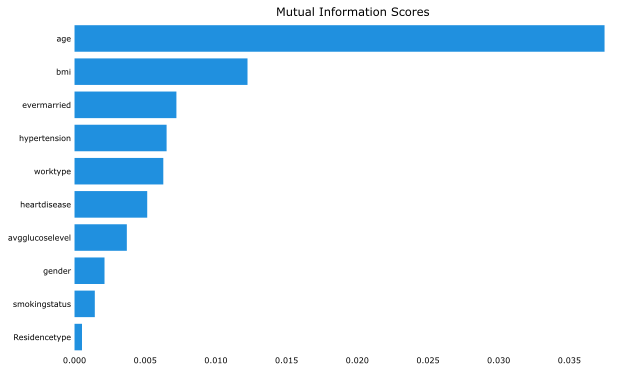

In [31]:
mi_scores_series.index = mi_scores_series.index.str.replace('cat|num|pass|_',
                                                            '',
                                                            regex=True)
plt.figure(figsize=(10, 6))
plt.title('Mutual Information Scores')
fig = sns.barplot(y=mi_scores_series.index,
                  x=mi_scores_series.values,
                  color=default_blue,
                  orient='horizontal')
hide_spines(fig)
plt.show()

- Our boxplot above displays the mutual information scores for our features vs our target variable. This gives us more insight (besides the statistical tests we performed) into which features might be useful for our models and which might not be. We can see that age has the highest score in relation to having a stroke, followed by bmi. Features such as gender and residence type seem to have a very low mutual information scores, possibly signifying they dont have much of a relationship with our target variable.

**Data Preprocessing Pipelines & Model Selection**

In [32]:
common_preprocessing_params_with_scaling = make_common_preprocessing()
common_preprocessing_params_without_scaling = make_common_preprocessing(
    input_scalers=['passthrough'])

stratified_kfold = StratifiedKFold(random_state=42, n_splits=5, shuffle=True)

In [33]:
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier()
}

In [34]:
hyperparameter_grids = {
    "RandomForest": {
        **common_preprocessing_params_without_scaling, 'classifier__n_estimators':
        sp_randint(50, 500),
        'classifier__max_depth':
        sp_randint(2, 10),
        'classifier__class_weight': ['balanced'],
        'classifier__bootstrap': [False, True]
    },
    "XGBoost": {
        **common_preprocessing_params_without_scaling, 'classifier__n_estimators':
        sp_randint(50, 500),
        'classifier__learning_rate':
        uniform(0.001, 1),
        'classifier__max_depth':
        sp_randint(2, 10),
        'classifier__subsample':
        uniform(0.5, 0.5),
        'classifier__min_split_loss':
        uniform(0, 5),
        'classifier__scale_pos_weight':
        np.linspace(20, 60, num=4)
    },
    "LogisticRegression": {
        **common_preprocessing_params_with_scaling, 'classifier__class_weight':
        [None, 'balanced']
    },
    'SVM': {
        **common_preprocessing_params_with_scaling, 'classifier__C':
        [0.1, 1, 10],
        'classifier__gamma': [0.01, 0.1],
        'classifier__kernel': ['rbf', 'linear']
    },
    'KNN': {
        **common_preprocessing_params_with_scaling, 'classifier__n_neighbors':
        [7, 9, 11],
        'classifier__weights': ['uniform'],
        'classifier__metric': ['euclidean', 'manhattan']
    }
}

In [63]:
results_list = random_search_cv(X_train,
                                y_train,
                                models,
                                numerical_cols,
                                categorical_cols_not_encoded,
                                categorical_cols_encoded,
                                param_grid=hyperparameter_grids,
                                scoring='average_precision',
                                cv=stratified_kfold)

In [36]:
cross_val_results = custom_cross_validation(results_list,
                                            X_train,
                                            y_train,
                                            cv_strategy=stratified_kfold)

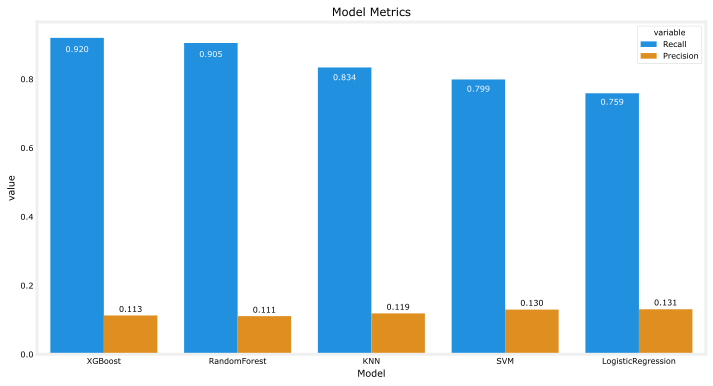

In [37]:
cross_val_result_melted = cross_val_results[[
    'Model', 'Recall', 'Precision'
]].sort_values(by='Recall', ascending=False).melt(id_vars='Model')
plt.figure(figsize=(12, 6))
plt.title('Model Metrics')
fig = sns.barplot(cross_val_result_melted,
                  x='Model',
                  y='value',
                  hue='variable')
annotate_bars(fig)

In [38]:
cross_val_results

,Model,Precision,Precision_Std,Recall,Recall_Std,ROC_AUC,Precision_Recall_AUC
0,RandomForest,0.111,0.005,0.905,0.029,0.835,0.172
1,XGBoost,0.113,0.005,0.920,0.033,0.834,0.184
2,LogisticRegression,0.131,0.011,0.759,0.046,0.836,0.189
3,SVM,0.130,0.011,0.799,0.035,0.840,0.189
4,KNN,0.119,0.008,0.834,0.021,0.816,0.155


- So far, we have developed preprocessing pipelines and explored a range of models, including bagging, boosting, linear, and distance-based approaches, along with various preprocessing techniques and basic hyperparameters. We have chose to optimize on the average precision metric as it provided the best balance between obtaining a high recall without completely discarding recall.

- Overall, our initial metrics indicate that the Random Forest and XGBoost performed best in terms of recall, effectively identifying class 1. On the other hand, the SVM and Logistic Regression provided a little bit of a better balance between precision and recall. Moving forward, we will be performing some feature engineering with the aim of further enhancing these metrics.

**Feature Engineering**

In [39]:
# Create copies incase we need to revert back
X_train_new = X_train.copy()
X_test_new = X_test.copy()

In [40]:
# Binning age by quartiles
bins = [0, 26, 45, 61, 82]
bin_labels = ['0-25 years', '26-44 years', '45-60 years', '61-82 years']
X_train_new['age_binned'] = pd.cut(X_train_new['age'],
                                   bins=bins,
                                   labels=bin_labels,
                                   include_lowest=True)
X_test_new['age_binned'] = pd.cut(X_test_new['age'],
                                  bins=bins,
                                  labels=bin_labels,
                                  include_lowest=True)

In [41]:
# Binning BMI by common knowledge
temp_imputer = SimpleImputer(strategy='mean')

X_train_new['bmi'] = temp_imputer.fit_transform(X_train_new[['bmi']])
X_test_new['bmi'] = temp_imputer.transform(X_test_new[['bmi']])
bins = [0, 18.5, 25, 30, float('inf')]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
X_train_new['bmi_binned'] = pd.cut(X_train_new['bmi'],
                                   bins=bins,
                                   labels=labels,
                                   include_lowest=True)
X_test_new['bmi_binned'] = pd.cut(X_test_new['bmi'],
                                  bins=bins,
                                  labels=labels,
                                  include_lowest=True)
X_train_new = X_train_new.drop(columns=['bmi', 'age'])

In [42]:
numerical_cols_new = ['avg_glucose_level']
categorical_cols_new = X_train_new.select_dtypes(exclude=np.number).columns

In [62]:
results_list_new_features = random_search_cv(X_train_new,
                                             y_train,
                                             models,
                                             numerical_cols_new,
                                             categorical_cols_new,
                                             categorical_cols_encoded,
                                             param_grid=hyperparameter_grids,
                                             scoring='average_precision',
                                             cv=stratified_kfold)

In [44]:
cross_val_new_features = custom_cross_validation(results_list_new_features,
                                                 X_train_new,
                                                 y_train,
                                                 cv_strategy=stratified_kfold)

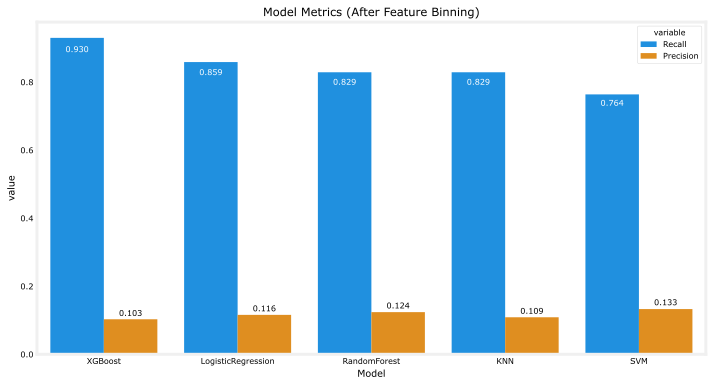

In [45]:
cross_val_result_new_melted = cross_val_new_features[[
    'Model', 'Recall', 'Precision'
]].sort_values(by='Recall', ascending=False).melt(id_vars='Model')
plt.figure(figsize=(12, 6))
plt.title('Model Metrics (After Feature Binning)')
fig = sns.barplot(cross_val_result_new_melted,
                  x='Model',
                  y='value',
                  hue='variable')
annotate_bars(fig)

In [46]:
cross_val_new_features

,Model,Precision,Precision_Std,Recall,Recall_Std,ROC_AUC,Precision_Recall_AUC
0,RandomForest,0.124,0.003,0.829,0.019,0.826,0.163
1,XGBoost,0.103,0.004,0.930,0.037,0.820,0.169
2,LogisticRegression,0.116,0.005,0.859,0.013,0.820,0.171
3,SVM,0.133,0.011,0.764,0.044,0.826,0.176
4,KNN,0.109,0.008,0.829,0.074,0.797,0.175


- After our initial model evaluations, we experimented with feature engineering to assess potential improvements. This involved binning ages into quartiles and categorizing BMI based on commonly accepted ranges (such as obesity levels). This new approach led to higher recall for the boosting model, but also a  slight decrease in precision. Moving forward, we will be testing and fine tuning the Random Forest and XGboost model with our original feature set as it performed slightly better in terms of precision.

**Feature Importance**

In [47]:
rf_pipeline = results_list[0]['Best_Estimator']

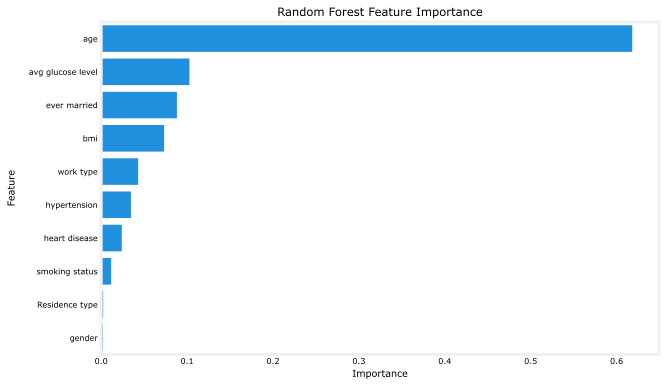

In [48]:
rf_feature_importances = extract_feature_importances(rf_pipeline)
rf_feature_importances['Feature'] = rf_feature_importances[
    'Feature'].str.replace('cat|num|pass|_', ' ', regex=True)
plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importance')
sns.barplot(data=rf_feature_importances,
            x='Importance',
            y='Feature',
            color=default_blue)
plt.show()

- Before moving ahead to our final models, I wanted to have a look at the feature importance to get a better understanding of which features might or might not be valuable for our model. We can see that residence type and gender basically have 0 importance, so we will be removing them.

**Random Forest**

In [49]:
# Removing gender and residence type
categorical_cols_not_encoded_features_removed = [
    col for col in categorical_cols_not_encoded
    if col not in ('gender', 'Residence_type')
]
rf_model = models['RandomForest']
rf_pipeline_features_removed = build_pipeline(
    rf_model,
    scaler='passthrough',
    imputer=KNNImputer(),
    encoder=TargetEncoder(),
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols_not_encoded_features_removed,
    passthrough_cols=categorical_cols_encoded)

In [50]:
new_param_grid_rf = {
    'classifier__n_estimators': sp_randint(100, 200),
    'classifier__max_depth': sp_randint(1, 10),
    'classifier__min_samples_split': sp_randint(5, 15),
    'classifier__min_samples_leaf': sp_randint(1, 10),
    'classifier__max_features': [None, 'sqrt', 'log2'],
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': ['balanced'],
    'classifier__max_leaf_nodes': [None] + list(range(30, 80)),
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'preprocessor__cat__encoder__smoothing': [0.25, 0.5, 1, 10],
    'preprocessor__num__imputer__n_neighbors': [1, 3, 5, 7, 9],
    'preprocessor__num__imputer__weights': ['uniform', 'distance']
}

random_search_rf = RandomizedSearchCV(rf_pipeline_features_removed,
                                      param_distributions=new_param_grid_rf,
                                      n_iter=100,
                                      cv=stratified_kfold,
                                      scoring='average_precision',
                                      random_state=42)
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                'passthrough')]),
                                                                               ['age',
                                                                                'avg_glucose_level',
                                                                                'bmi']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                TargetEncoder())]),
                                                                               ['ever_married',
                                                                                'work_type',
                                                                                'smoki...
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14d3d5360>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14d3d52d0>,
                                        'preprocessor__cat__encoder__smoothing': [0.25,
                                                                                  0.5,
                                                                                  1,
                                                                                  10],
                                        'preprocessor__num__imputer__n_neighbors': [1,
                                                                                    3,
                                                                                    5,
                                                                                    7,
                                                                                    9],
                                        'preprocessor__num__imputer__weights': ['uniform',
                                                                                'distance']},
                   random_state=42, scoring='average_precision')

In [56]:
random_search_rf.best_params_

{'classifier__bootstrap': True,
 'classifier__class_weight': 'balanced',
 'classifier__criterion': 'log_loss',
 'classifier__max_depth': 3,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': 49,
 'classifier__min_samples_leaf': 7,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 166,
 'preprocessor__cat__encoder__smoothing': 10,
 'preprocessor__num__imputer__n_neighbors': 3,
 'preprocessor__num__imputer__weights': 'uniform'}

In [51]:
rf_final_pipeline = random_search_rf.best_estimator_

In [53]:
y_preds = rf_final_pipeline.predict(X_test)
y_probas = rf_final_pipeline.predict_proba(X_test)[:, -1]
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probas)
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
roc_auc = roc_auc_score(y_test, y_probas)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80       972
           1       0.12      0.84      0.20        50

    accuracy                           0.68      1022
   macro avg       0.55      0.75      0.50      1022
weighted avg       0.95      0.68      0.77      1022



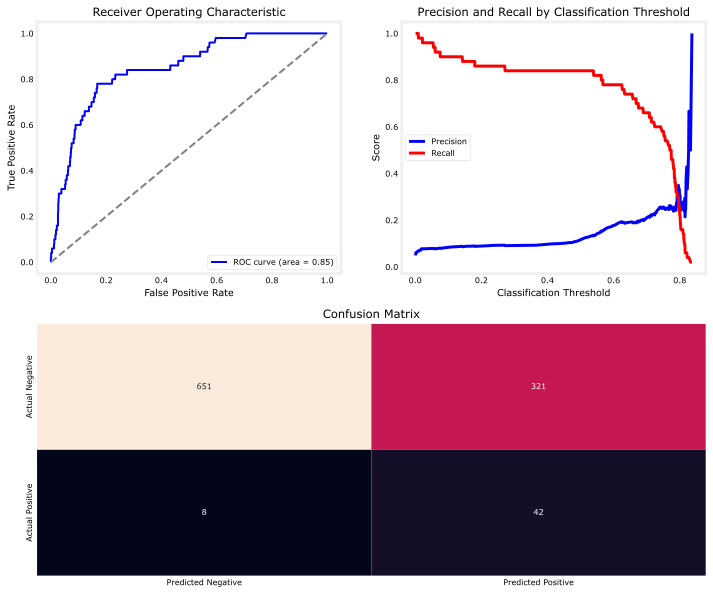

In [55]:
conf_matrix_rf = confusion_matrix_df(y_test, y_preds)
plot_model_evaluation(fpr, tpr, roc_auc, thresholds_pr, precision, recall,
                      conf_matrix_rf)

In [57]:
# Testing a slight change in threshold
threshold = 0.56

y_preds_adjusted = (y_probas >= threshold).astype(int)
print(classification_report(y_test, y_preds_adjusted))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86       972
           1       0.15      0.82      0.25        50

    accuracy                           0.76      1022
   macro avg       0.57      0.79      0.56      1022
weighted avg       0.95      0.76      0.83      1022



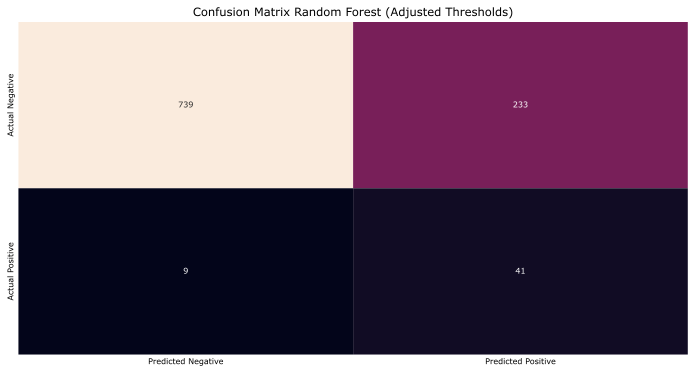

In [58]:
confusion_matrix_adjusted = confusion_matrix_df(y_test, y_preds_adjusted)

plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix_adjusted, annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix Random Forest (Adjusted Thresholds)')
plt.show()

- After fine-tuning our final random forest model, we conducted an evaluation on our test set. The initial assessment resulted in a recall of 0.84 and a precision of approximately 0.12 for class 1, along with an ROC AUC of 0.85. Additionally, by analyzing the precision-recall curve, we were able to explore different thresholds to achieve a more balanced trade-off between precision and recall. The initial confusion matrix revealed a decent model in identifying both negative and positive cases, with a small number of false negatives (8). However, the model also presented a significant number of false positives (321), reflecting the low precision score.

- Upon adjusting the thresholds, we observed a reduction in false positives, decreasing to 233. This adjustment, however, led to a slight decrease in recall.

**Shap Values (Random Forest)**

In [83]:
X_test_preprocessed = rf_final_pipeline.named_steps['preprocessor'].transform(
    X_test)
explainer = shap.TreeExplainer(rf_final_pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(X_test_preprocessed)
feature_names = numerical_cols + categorical_cols_not_encoded_features_removed + categorical_cols_encoded

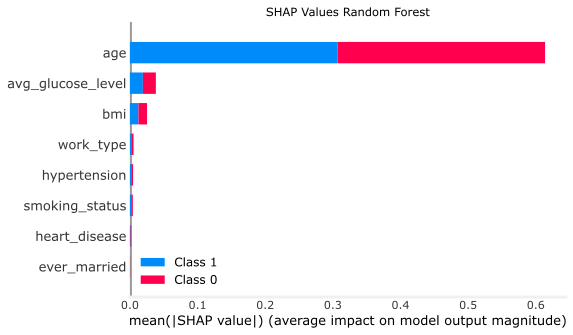

In [87]:
plt.title('SHAP Values Random Forest')
shap.summary_plot(shap_values, feature_names=feature_names, show=False)
plt.show()

- In summary, for predicting a stroke, the model heavily weighs age, followed by  average glucose and bmi but to a lesser extent. Older individuals or those with higher glucose levels are more likely to be predicted as having a higher risk of stroke. Additionally, a high BMI, certain types of work, the presence of hypertension or heart disease, a person's smoking status, and their marital status had very little impact on the predictions.

**XGBoost**

In [68]:
xgb_pipeline = results_list[1]['Best_Estimator']

In [69]:
xgb_paramgrid = {
    'classifier__n_estimators': sp_randint(100, 300),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__max_depth': sp_randint(1, 10),
    'classifier__subsample': uniform(0.5, 0.5),
    'classifier__min_child_weight': sp_randint(1, 10),
    'classifier__min_split_loss': uniform(2, 6),
    'classifier__scale_pos_weight': np.linspace(20, 60, num=4),
    'classifier__colsample_bytree': uniform(0.5, 0.5),
    'preprocessor__num__imputer__n_neighbors': [1, 3, 5, 7, 9],
    'preprocessor__num__imputer__weights': ['uniform', 'distance']
}

random_search_xgb = RandomizedSearchCV(xgb_pipeline,
                                       param_distributions=xgb_paramgrid,
                                       n_iter=100,
                                       cv=stratified_kfold,
                                       scoring='average_precision',
                                       random_state=42)
random_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                'passthrough')]),
                                                                               ['age',
                                                                                'avg_glucose_level',
                                                                                'bmi']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(drop='if_binary'))]),
                                                                               ['gender',
                                                                                'ever_ma...
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14d438220>,
                                        'classifier__scale_pos_weight': array([20.        , 33.33333333, 46.66666667, 60.        ]),
                                        'classifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14d3d4f10>,
                                        'preprocessor__num__imputer__n_neighbors': [1,
                                                                                    3,
                                                                                    5,
                                                                                    7,
                                                                                    9],
                                        'preprocessor__num__imputer__weights': ['uniform',
                                                                                'distance']},
                   random_state=42, scoring='average_precision')

In [70]:
random_search_xgb.best_params_

{'classifier__colsample_bytree': 0.9103197378719776,
 'classifier__learning_rate': 0.13518793402031457,
 'classifier__max_depth': 1,
 'classifier__min_child_weight': 1,
 'classifier__min_split_loss': 5.908908631146728,
 'classifier__n_estimators': 142,
 'classifier__scale_pos_weight': 60.0,
 'classifier__subsample': 0.6369805636605669,
 'preprocessor__num__imputer__n_neighbors': 7,
 'preprocessor__num__imputer__weights': 'uniform'}

In [71]:
xgb_final_pipeline = random_search_xgb.best_estimator_

In [72]:
y_preds = xgb_final_pipeline.predict(X_test)
y_probas = xgb_final_pipeline.predict_proba(X_test)[:, -1]
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probas)
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
roc_auc = roc_auc_score(y_test, y_probas)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.58      0.73       972
           1       0.09      0.84      0.17        50

    accuracy                           0.59      1022
   macro avg       0.54      0.71      0.45      1022
weighted avg       0.94      0.59      0.70      1022



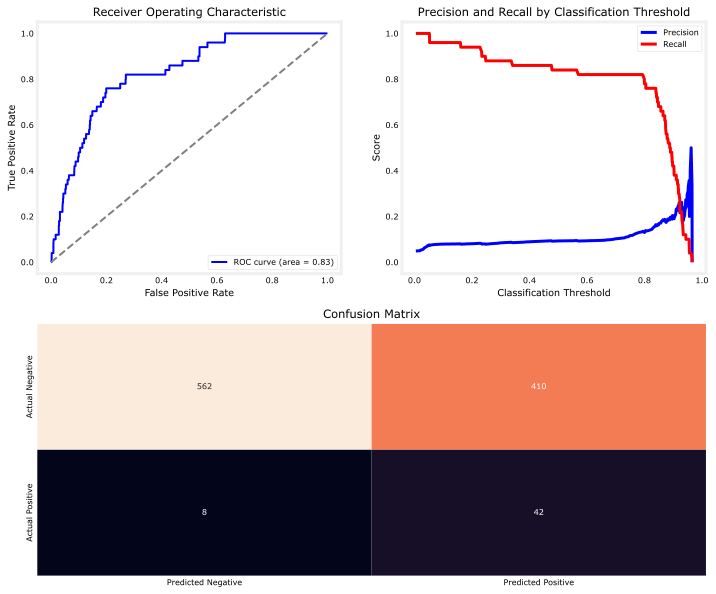

In [73]:
conf_matrix_xgb = confusion_matrix_df(y_test, y_preds)
plot_model_evaluation(fpr, tpr, roc_auc, thresholds_pr, precision, recall,
                      conf_matrix_xgb)

In [99]:
threshold = 0.78

y_preds_adjusted = (y_probas >= threshold).astype(int)
print(classification_report(y_test, y_preds_adjusted))

              precision    recall  f1-score   support

           0       0.99      0.72      0.83       972
           1       0.13      0.82      0.22        50

    accuracy                           0.72      1022
   macro avg       0.56      0.77      0.53      1022
weighted avg       0.95      0.72      0.80      1022



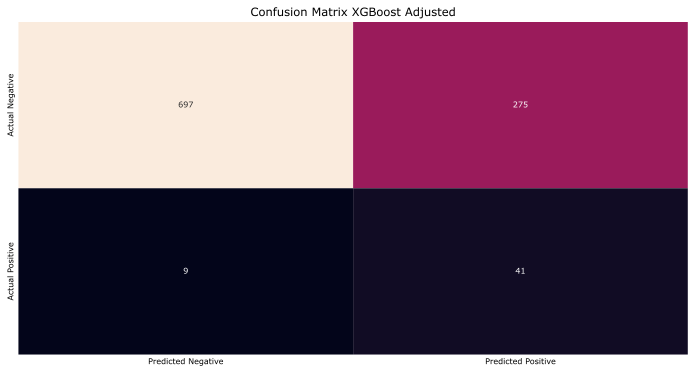

In [100]:
confusion_matrix_adjusted = confusion_matrix_df(y_test, y_preds_adjusted)
plt.figure(figsize=(12, 6))
plt.title('Confusion Matrix XGBoost Adjusted')
sns.heatmap(confusion_matrix_adjusted, annot=True, fmt='g', cbar=False)
plt.show()

- After fine-tuning our xgboost  model, we conducted an evaluation on our test set. The initial assessment showed very similar results to our random forest with a recall of 0.84 and a precision of approximately 0.09 for class 1, along with an ROC AUC of 0.84. Our confusion matrices also show that this model was very good at identifying positive instances but once again was raising a lot of false positives.
- In the end, our Random Forest model performed slightly better so that will be our final model we will be deploying.

**Saving Final Pipeline/Model**

In [94]:
dump(rf_final_pipeline, 'rf_final_pipeline.joblib')

**Conclusion**

**Analysis** - Our analysis of patient attributes in relation to stroke risk has yielded key insights. Notably, hypertension and heart disease tended to have higher stroke rates of 13% and 17%, respectively, compared to much lower rates in those without these conditions. The data indicated a correlation of stroke incidence with age; patients who experienced a stroke had a median age of 71, as opposed to 43 in those who did not. Average glucose levels and BMI were slightly higher in stroke patients. Through statistical testing, we confirmed significant associations between stroke occurrence and factors such as hypertension, heart disease, marital status, employment type, and smoking status. Conversely, gender and residence type showed no significant relationship with stroke incidence.

**Modeling** - Establishing a baseline model highlighted the challenge of our class imbalance, with initial predictions heavily skewed towards the majority class. Due to the nature of the problem, recall became our metric to optimize, given the high stakes of missing true stroke cases. Mutual information scores further refined our understanding, pinpointing age as a prominent feature linked to stroke risk. Our testing of various models and feature engineering techniques revealed that the Random Forest and XGBoost models, after fine-tuning, provided the most promising results in terms of recall. The Random Forest model, in particular, was selected for deployment due to its slightly superior performance. We achieved a recall of of 82%, precision of 15% and ROC AUC OF 85%. Our SHAP values displayed that age was the main feature that contributed to our model, followed by average glucose level and BMI.

**Business Perspective** - The implications of our findings are significant from a healthcare perspective. The identified relationships and model predictions can inform medical professionals and policymakers in creating targeted screening and prevention strategies, particularly for individuals in higher-risk categories such as older age groups and those with pre-existing health conditions. The ability of our Random Forest model to predict potential stroke cases, given its high recall (84%) and reasonable precision after threshold adjustments, presents an opportunity to mitigate stroke risk pro-actively.

**Suggestions For Improvement**:
- Further data collection could enhance the model's predictive accuracy and broaden our understanding of stroke risk factors.
- Incorporating additional patient features could uncover new relationships and improve model performance.